# Новая метрика вместо CTR - linearized likes
Цель использования новой метрики:
увеличить чувствительность нашей метрики.

In [22]:
import pandas as pd
import pandahouse as ph
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

connection = {'host': '***',
                      'database':'***',
                      'user':'***', 
                      'password':'***'
                     }

In [7]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') AS likes,
    sum(action = 'view') AS views
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-31' AND '2023-06-06'
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.head()

,exp_group,user_id,likes,views
0,3,115383,9,30
1,1,18392,7,32
2,3,123580,13,48
3,2,131473,14,134
4,4,107323,5,31


In [8]:
CTRcontrol = sum(df['likes'])/sum(df['views'])
CTRcontrol

0.20950954969876226

In [9]:
df['linearized_likes'] = df['likes'] - CTRcontrol * df['views']
df.head()

,exp_group,user_id,likes,views,linearized_likes
0,3,115383,9,30,2.714714
1,1,18392,7,32,0.295694
2,3,123580,13,48,2.943542
3,2,131473,14,134,-14.074280
4,4,107323,5,31,-1.494796


In [19]:
group1 = df[df.exp_group == 1].linearized_likes
group2 = df[df.exp_group == 2].linearized_likes

group0 = df[df.exp_group == 0].linearized_likes
group3 = df[df.exp_group == 3].linearized_likes

##  Группы 1 и 2

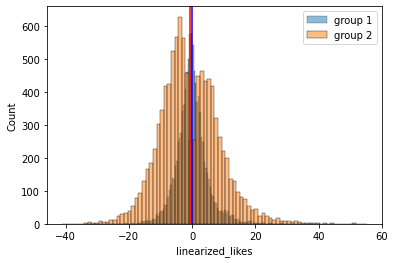

In [16]:
sns.histplot(group1, label='group 1', alpha=0.5)
sns.histplot(group2, label='group 2', alpha=0.5)
plt.axvline(x=group1.mean(), color='blue')
plt.axvline(x=group2.mean(), color='red')
plt.legend()

In [17]:
alpha=0.05
t, p_value = ttest_ind(group1,group2, equal_var=False)
print('p-value is', p_value)
if p_value <= alpha:
    print('Мы можем отклонить нулевую гипотезу о равенстве linearized likes в группах 1 и 2')
else:
    print('У нас недостаточно оснований, чтобы отклонить нулевую гипотезу')

p-value is 1.022347621361936e-09
Мы можем отклонить нулевую гипотезу о равенстве linearized likes в группах 1 и 2


1. Распределения уже больше похожи на нормальные, нет явной бимодальности.
2. Снова метрика в группе 2 отличается бОльшим разбросом в обе стороны. Отличия очень заметны визуально,
3. p-value стало достаточно низким, чтобы отклонить нулевую гипотезу.

## Группы 0 и 3

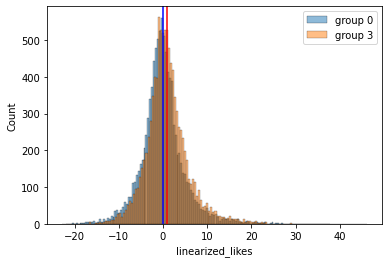

In [20]:
sns.histplot(group0, label='group 0', alpha=0.5)
sns.histplot(group3, label='group 3', alpha=0.5)
plt.axvline(x=group0.mean(), color='blue')
plt.axvline(x=group3.mean(), color='red')
plt.legend()

In [21]:
t, p_value = ttest_ind(group0,group3, equal_var=False)
print('p-value is', p_value)
if p_value <= alpha:
    print('Мы можем отклонить нулевую гипотезу о равенстве linearized likes в группах 0 и 3')
else:
    print('У нас недостаточно оснований, чтобы отклонить нулевую гипотезу')

p-value is 6.414519106059481e-52
Мы можем отклонить нулевую гипотезу о равенстве linearized likes в группах 0 и 3


1. Распределения выглядят похоже, но распределение группы 3 смещено немного правее.
2. Как и в случае с CTR, p-value для linearized likes намного меньше нашего уровня значимости.